# Theoretical Neuroscience: Project 1

**Professor:** Brian Frost

**Spring 2025**

---

This notebook implements spike‐train generation using concepts from Chapter 1 of _Dayan and Abbott’s Theoretical Neuroscience_.

We consider:

- **Homogeneous Poisson Process:** Spike trains with a constant firing rate

- **Inhomogeneous Poisson Process:** Spike trains with a time‐varying firing rate

- **Refractory Period:** After a spike the neuron is “blocked” for an interval drawn from a hard‐coded (exponential) distribution

Computations for each process (with and without refractoriness):

- The **Fano factor** (variance/mean of spike counts over many trials)

- The **interspike interval (ISI) probability distributions**

- The **coefficient of variation (CV)** of the ISIs

- The **spike‐train autocorrelation function**

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union

### Helper Functions

In [103]:
def spike_train2spike_times(spike_train: np.ndarray, dt: float):
    return np.where(spike_train)[0] * dt # np.where returns a tuple where the first element is an array of the indices of the True values in the input array
spike_train2spike_times(np.array([0, 1, 0, 1, 0]), dt=0.001)

array([0.001, 0.003])

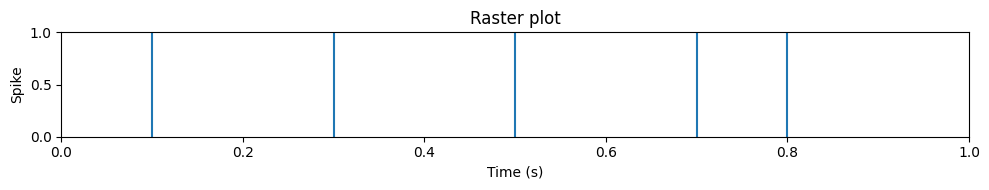

In [104]:
def raster_plot(ax, spike_times, xlim=(0, 1), title="Raster plot"):
    ax.vlines(spike_times, 0, 1)  # Plot vertical lines for spikes
    ax.set_ylim(0, 1)
    ax.set_xlim(xlim)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Spike")
    ax.set_title(title)
    
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
raster_plot(ax, [0.1, 0.3, 0.5, 0.7, 0.8], title="Raster plot")
plt.tight_layout()
plt.show()


## Spike Train Generation

**Poisson Process**

The poisson distribution is given by

$$
P_T[n] = \frac{(rT)^n}{n!} \exp(-rT).
$$

where $P_T[n]$ is the probability of observing $n$ spikes in time $T$ given a firing rate of $r$. For a homogeneous poisson process, the firing rate is constant; for an inhomogeneous poisson process, the firing rate is time-varying.

**Refractory Period**

> "For a few milliseconds just after an action potential has been fired, it may be virtually impossible to initiate another spike. This is called the absolute refractory period." ({cite}`dayan_theoretical_2001`, p.21)

> "Refractory effects can be incorporated into a Poisson model of spike generation by setting the firing rate to 0 immediately after a spike is fired, and then letting it return to its predicted value according to some dynamic rule such as an exponential recovery." ({cite}`dayan_theoretical_2001`, p.48)

> "Both the length of the absolute and relative refractory period depend on the nerve cell under consideration, but typical values in the central nervous system are 0.5–1 ms and ≈ 10 ms, respectively." {cite}`gabbiani_mathematics_2010`

The rule I implemented is an absolute refractory period of 1 ms summed with a relative refractory period drawn from an exponential distribution with a mean of 10 ms.
The exponential distribution is given by

$$
f(x; \frac{1}{\beta}) = \frac{1}{\beta} \exp(-\frac{x}{\beta}),
$$

where $\beta$ is the mean of the distribution.


In [105]:
# Initialize random number generator
rng = np.random.default_rng()

### Simple Spike Generator

For the spike generation I initially used the following procedure:

> "Spike sequences can be simulated by using some estimate of the firing rate, $r_{\text{est}}(t)$, predicted from knowledge of the stimulus, to drive a Poisson process. A simple procedure for generating spikes in a computer program is based on the fact that the estimated probability of firing a spike during a short interval of duration $\Delta t$ is $r_{\text{est}}(t) \Delta t$. The program progresses through time in small steps of size $\Delta t$ and generates, at each time step, a random number $x*{\text{rand}}$ chosen uniformly in the range between 0 and 1. If $r_{\text{est}}(t) \Delta t > x\_{\text{rand}}$ at that time step, a spike is fired; otherwise it is not." ({cite}`dayan_theoretical_2001`, p.47)

In [119]:
def simple_spike_generator(
    r: Union[float, np.ndarray],
    T: float = 1,
    dt: float = 0.001,
    refractory: bool = False,
    abs_ref: float = 0.001,
    rel_ref_mean: float = 0.01,
) -> np.ndarray:
    """Generate a spike train array according to a Poisson process.

    Args:
        r (Union[float, np.ndarray]): Firing rate in Hz (if scalar) or array of firing rates at each time step.
        T (float, optional): Trial duration in seconds. Defaults to 1.
        dt (float, optional): Time step size in seconds. Defaults to 0.001.
        refractory (bool, optional): Whether to include refractory periods. Defaults to False.
        abs_ref (float, optional): Absolute refractory period in seconds. Defaults to 0.001.
        rel_ref_mean (float, optional): Mean relative refractory period in seconds. Defaults to 0.01.

    Returns:
        np.ndarray: spike train array; when a spike is present, the value is 1, otherwise 0.
    """
    spike_train_length = int(T / dt)
    spike_train = np.zeros(spike_train_length)
    next_possible_index = 0  # index until which the neuron is refractory
    
    for i in range(spike_train_length):
        if i < next_possible_index:
            continue

        # Use a homogeneous firing rate if r is scalar, inhomogeneous otherwise (r should be an array of the same length as spike_train)
        firing_rate = r if np.isscalar(r) else r[i]
        if np.random.random() < firing_rate * dt:
            spike_train[i] = 1
            if refractory:
                ref_period = abs_ref + np.random.exponential(scale=rel_ref_mean)
                ref_time_steps = int(np.ceil(ref_period / dt))
                next_possible_index = i + ref_time_steps

    return spike_train
simple_spike_generator(60)[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [ ]:
# Define parameters
T = 1 
dt = 0.001
abs_ref = 0.001
rel_ref_mean = 0.01
r = 60

# Time varying firing rate
r_t = np.repeat([0, 30, 60, 30, 0], int((T/dt)/5))
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(np.arange(0, T, dt), r_t)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Firing rate (Hz)")
ax.set_title("Time-varying firing rate")
plt.tight_layout()
plt.show()

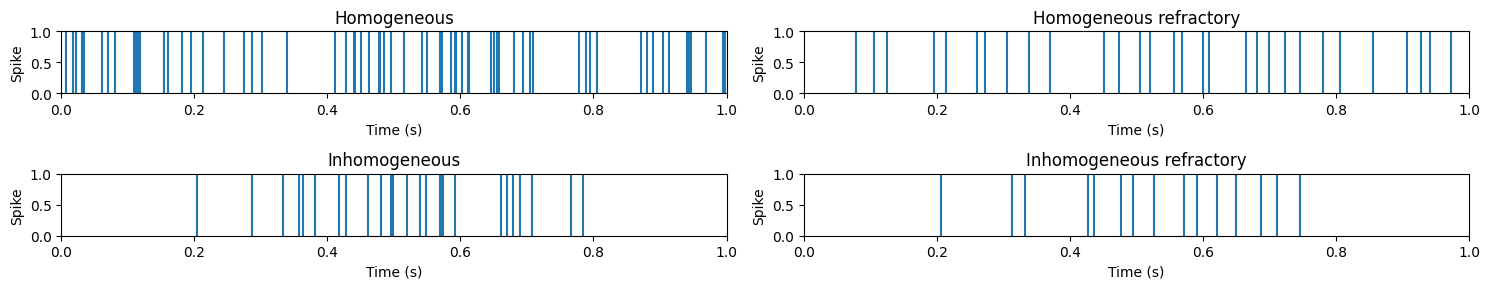

In [ ]:
# Generate spike trains
simple_spike_train_homogeneous = simple_spike_generator(r, T=T, dt=dt, abs_ref=abs_ref, refractory=False, rel_ref_mean=rel_ref_mean)
simple_spike_train_homogeneous_refractory = simple_spike_generator(r, T=T, dt=dt, abs_ref=abs_ref, refractory=True, rel_ref_mean=rel_ref_mean)
simple_spike_train_inhomogeneous = simple_spike_generator(r_t, T=T, dt=dt, abs_ref=abs_ref, refractory=False, rel_ref_mean=rel_ref_mean)
simple_spike_train_inhomogeneous_refractory = simple_spike_generator(r_t, T=T, dt=dt, abs_ref=abs_ref, refractory=True, rel_ref_mean=rel_ref_mean)

# Plot spike trains
fig, axes = plt.subplots(2, 2, figsize=(15, 3))
raster_plot(axes[0, 0], spike_train2spike_times(simple_spike_train_homogeneous, dt=dt), title="Homogeneous")
raster_plot(axes[0, 1], spike_train2spike_times(simple_spike_train_homogeneous_refractory, dt=dt), title="Homogeneous refractory")
raster_plot(axes[1, 0], spike_train2spike_times(simple_spike_train_inhomogeneous, dt=dt), title="Inhomogeneous")
raster_plot(axes[1, 1], spike_train2spike_times(simple_spike_train_inhomogeneous_refractory, dt=dt), title="Inhomogeneous refractory")
fig.tight_layout()

### Interspike Interval Spike Generators

> For a constant firing rate, it is faster to compute spike times $t_i$ for $i = 1, 2, ... n$ iteratively by generating interspike intervals from an exponential probability density

**Comparison**
- The precision is limited by the bin size in the simple generator, while generating the interspike intervals will allow for up to 17 decimal point precision {cite}`python_floating-point_2025`.
- Simple generator can generate arbitrary number of spikes per trial, while the fast generator guarentees $n$ spikes per trial


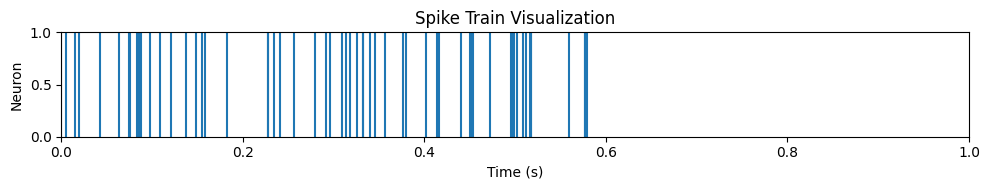

In [117]:
def fast_spike_generator_homogeneous(
    r: int,
    T: float,
    refractory: bool = False,
    abs_ref: float = 0.001,
    rel_ref_mean: float = 0.01,
) -> np.ndarray:
    """Generate a spike time array according to an homogeneous Poisson process with rate _r_

    Args:
        r (int): firing rate (Hz)
        T (float): trial duration (s)
        refractory (bool, optional): whether to include refractory periods. Defaults to False.
        abs_ref (float, optional): absolute refractory period (s). Defaults to 0.001.
        rel_ref_mean (float, optional): mean relative refractory period (s). Defaults to 0.01.

    Returns:
        np.ndarray: spike time array where each entry represents a spike in time (s)
    """
    interspike_intervals = rng.exponential(scale=rel_ref_mean, size=r * T)
    
    spike_times = np.cumsum(interspike_intervals)
    
    return spike_times

r = 60
T = 1
abs_ref = 0.001
rel_ref_mean = 0.01

fast_spike_times_homogeneous = fast_spike_generator_homogeneous(60, T=T, abs_ref=abs_ref, refractory=True, rel_ref_mean=rel_ref_mean)
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
raster_plot(ax, fast_spike_times_homogeneous, title="Homogeneous Fast Spike Train")
plt.xlabel("Time (s)")
plt.ylabel("Neuron")
plt.title("Spike Train Visualization")
plt.tight_layout()

Make faster spike generator from textbook

implement spike thinning

make raster plots

do computations

research firing rates

```{bibliography}
```